# Energy Prediction Notebook

This notebook demonstrates a comprehensive workflow for forecasting regional energy demand using a variety of machine learning models. The workflow includes robust feature engineering, model training, evaluation, and comparison across multiple advanced regression algorithms.

---

## **Workflow Overview**

1. **Data Preparation**
    - Regional energy consumption and weather data are loaded and merged.
    - Data is split into training and test sets for each region.

2. **Feature Engineering**
    - **Lagged Features:** Past values of temperature and energy are added as features to capture temporal dependencies.
    - **Calendar Features:** Month, day of week, and weekend indicators are extracted to model seasonality and weekly patterns.
    - **Sin/Cos Seasonality:** Sine and cosine transformations of the day of year are used to encode annual seasonality in a continuous, cyclical manner.
    - **Interaction Features:** Multiplicative interactions between temperature and lagged energy are included to capture non-linear effects.
    - **Dimensionality Reduction & Selection (in pipelines):** Feature selection (SelectKBest) and Principal Component Analysis (PCA) are used in some pipelines to reduce noise and multicollinearity.

3. **Model Training & Evaluation**
    - Multiple machine learning models are trained for each region.
    - Performance is evaluated using RMSE (Root Mean Squared Error) and R² (coefficient of determination).
    - Results are visualized and compared across models and regions.

---

## **Models Implemented**

1. **XGBoost Regressor**
    - A powerful gradient boosting tree model, robust to outliers and capable of capturing complex relationships.

2. **Support Vector Regression (SVR)**
    - A kernel-based regression model effective for non-linear relationships.

3. **Random Forest Regressor**
    - An ensemble of decision trees that reduces overfitting and improves generalization.

4. **Linear Regression**
    - A simple, interpretable baseline model for linear relationships.

5. **LightGBM Regressor**
    - A fast, efficient gradient boosting framework optimized for large datasets.

6. **Gradient Boosting Regressor**
    - Another tree-based boosting model, similar to XGBoost but from scikit-learn.

7. **Ridge Regression**
    - Linear regression with L2 regularization to handle multicollinearity and prevent overfitting.

8. **SVR Pipeline**
    - A pipeline combining scaling, feature selection, PCA, and SVR to improve performance by preprocessing features.

9. **XGBoost + SVR Stacking Ensemble**
    - A stacking regressor that combines predictions from an SVR pipeline and XGBoost, using another XGBoost as a meta-learner for improved accuracy.

10. **LSTM Neural Network**
     - A deep learning model (Long Short-Term Memory) designed for sequential data, capturing long-term temporal dependencies in energy demand.

---

## **Feature Engineering**

- **Lagged Features:**  
  - `Temp_lag1`, `Temp_lag2`, `Temp_lag3`: Previous days' temperatures.
  - `Energy_lag1`, `Energy_lag2`, `Energy_lag3`, `Energy_lag7`: Previous days' energy consumption.

- **Calendar Features:**  
  - `month`, `dayofweek`, `is_weekend`: Encodes seasonality and weekly cycles.

- **Seasonality (Sin/Cos):**  
  - `sin_DOY`, `cos_DOY`: Encodes cyclical annual patterns.

- **Interaction Features:**  
  - `Temp_x_lag1`, `Temp_x_lag2`: Captures non-linear effects between temperature and past energy.

- **Advanced Pipelines:**  
  - **Scaling:** Standardizes features for models sensitive to feature scale (e.g., SVR).
  - **Feature Selection:** Selects the most informative features.
  - **PCA:** Reduces dimensionality and noise, improving model robustness.



---

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
MERGED_DIR = Path("merged_energy_temp")
MAX_LAG    = 3                            # 1- to 3-day temp lags
TEST_SPLIT = 0.80                         # 80 % train, 20 % test

In [3]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add calendar, lagged temp / energy, sinusoidal seasonality,
    and simple interaction features.
    """
    # Ensure a DatetimeIndex
    if "Datetime" in df.columns:
        df["Datetime"] = pd.to_datetime(df["Datetime"])
        df = df.set_index("Datetime")
    else:
        df.index = pd.to_datetime(df.index)

    # Calendar
    df["month"]      = df.index.month
    df["dayofweek"]  = df.index.dayofweek          # Mon=0 … Sun=6
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    # Temperature lags
    for lag in range(1, MAX_LAG + 1):
        df[f"Temp_lag{lag}"] = df["Estimated_Temp_C"].shift(lag)

    # Energy lags
    for lag in [1, 2, 3, 7]:
        df[f"Energy_lag{lag}"] = df["Energy"].shift(lag)

    # Day-of-year sinusoid
    doy = df.index.dayofyear
    df["sin_DOY"] = np.sin(2 * np.pi * doy / 365.25)
    df["cos_DOY"] = np.cos(2 * np.pi * doy / 365.25)

    # Simple interaction
    df["Temp_x_lag1"] = df["Estimated_Temp_C"] * df["Energy_lag1"]
    df["Temp_x_lag2"] = df["Estimated_Temp_C"] * df["Energy_lag2"]

    return df

FEATURE_COLS = [
    "Estimated_Temp_C",
    *(f"Temp_lag{i}" for i in range(1, MAX_LAG + 1)),
    "Energy_lag1", "Energy_lag2", "Energy_lag3", "Energy_lag7",
    "month", "dayofweek", "is_weekend",
    "sin_DOY", "cos_DOY",
    "Temp_x_lag1", "Temp_x_lag2",
]

In [4]:
files = sorted(MERGED_DIR.glob("*_merged.csv"))
assert files, f"No *_merged.csv found in {MERGED_DIR.resolve()}"

data_dict = {}
for csv_path in files:
    region = csv_path.stem.split("_")[0]                      # e.g. "TX" from "TX_merged.csv"
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    # First column is energy usage; rename for clarity
    df = df.rename(columns={df.columns[0]: "Energy"})
    df["Estimated_Temp_C"] = df["Estimated_Temp_C"].astype(float)

    df = make_features(df).dropna().sort_index()

    X = df[FEATURE_COLS].values
    y = df["Energy"].values
    split = int(len(df) * TEST_SPLIT)

    data_dict[region] = {
        "X_train": X[:split],  "y_train": y[:split],
        "X_test":  X[split:],  "y_test":  y[split:],
        "index_test": df.index[split:],
    }

print(f"Loaded {len(data_dict)} regions: {list(data_dict)}")

Loaded 12 regions: ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJM', 'PJME', 'PJMW']


# ML models

## <span style="color:blue">1. XGBoost ML model</span>


The code below demonstrates how to use the XGBoost machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of gradient boosted decision trees, widely used for regression and classification tasks due to its high performance and scalability.

**What the code does:**
- For each region, it trains an `XGBRegressor` model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use XGBoost?**
- XGBoost is known for its speed and performance, especially on structured/tabular data.
- It handles missing values and supports regularization to reduce overfitting.
- It can capture complex, non-linear relationships in the data.
- It is robust to outliers and can handle large datasets efficiently.

In this notebook, XGBoost is used to model the relationship between temperature, seasonal effects, and energy consumption, providing accurate predictions and insights into regional energy demand patterns.

In [5]:
import xgboost as xgb          # add more models if desired

def train_xgb(X_tr, y_tr):
    """Simple XGBRegressor with sane defaults."""
    return xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.06,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ).fit(X_tr, y_tr)

In [6]:
results = {}

for region, d in data_dict.items():
    model = train_xgb(d["X_train"], d["y_train"])
    preds = model.predict(d["X_test"])

    rmse = np.sqrt(mean_squared_error(d["y_test"], preds))
    r2   = r2_score(d["y_test"], preds)

    results[region] = {
        "rmse": rmse,
        "r2": r2,
        "y_test": d["y_test"],
        "y_pred": preds,
        "index_test": d["index_test"],
    }

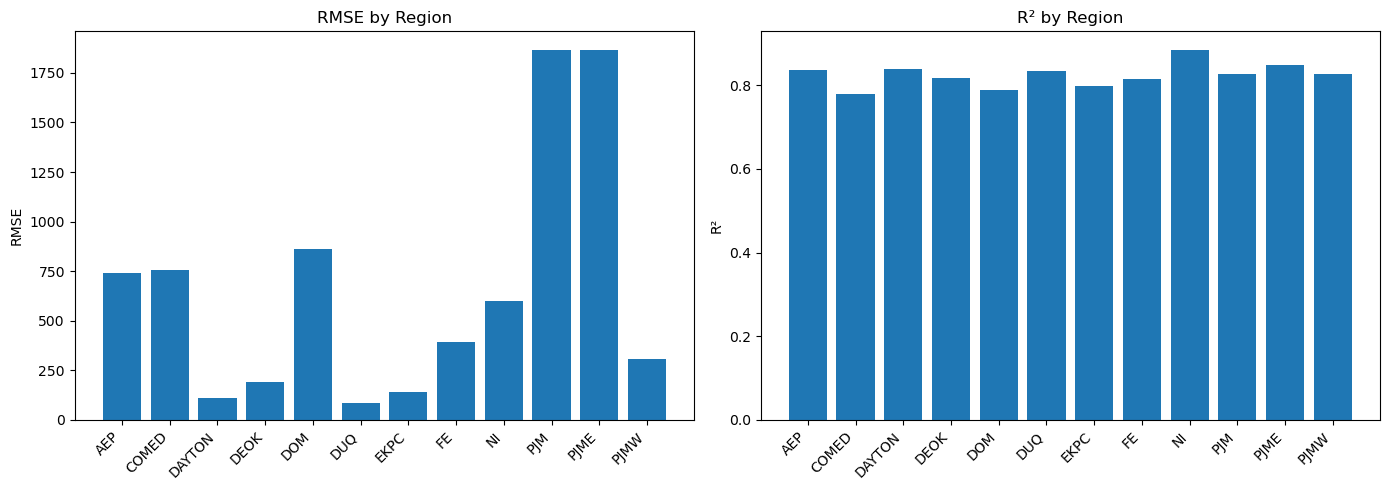

In [7]:
regions = list(results)
rmses   = [results[r]["rmse"] for r in regions]
r2s     = [results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# left chart
ax[0].bar(regions, rmses)
ax[0].set_title("RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha='right')

# right chart
ax[1].bar(regions, r2s)
ax[1].set_title("R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha='right')

plt.tight_layout()
plt.show()

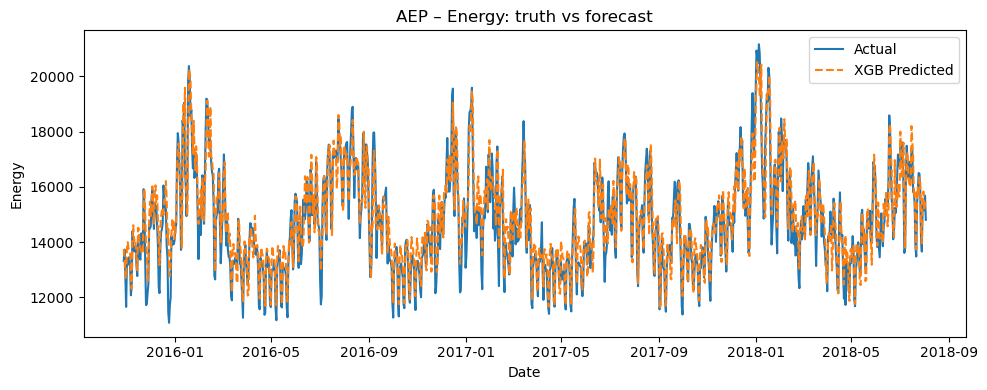

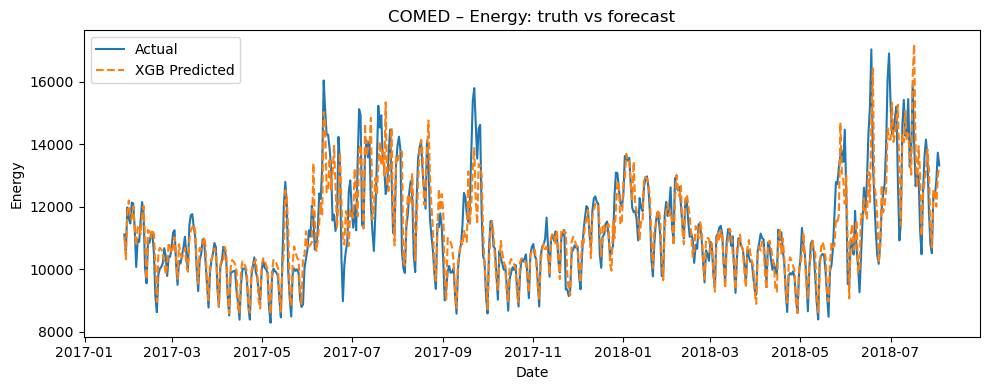

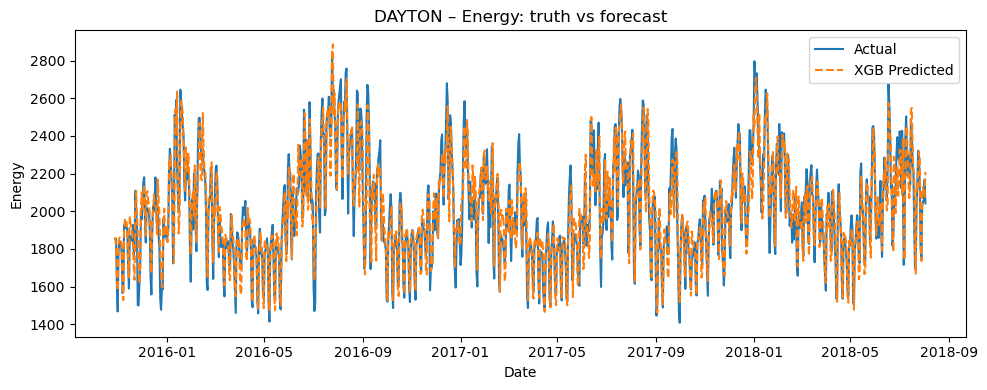

In [8]:
for region in regions[:3]:
    idx = results[region]["index_test"]
    yt  = results[region]["y_test"]
    yp  = results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt,  label="Actual")
    plt.plot(idx, yp, "--", label="XGB Predicted")
    plt.title(f"{region} – Energy: truth vs forecast")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:pink">2. SVR ML model</span>

The code below demonstrates how to use the Support Vector Regression (SVR) machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. SVR is a regression technique based on Support Vector Machines (SVM), which is widely used for both classification and regression tasks due to its flexibility and ability to model complex relationships.

**What the code does:**
- For each region, it trains an `SVR` model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use SVR?**
- SVR is effective for capturing non-linear relationships in data by using different kernel functions (e.g., RBF, polynomial).
- It is robust to outliers due to the use of a margin of tolerance (epsilon) around the regression line.
- SVR can perform well on smaller datasets and is less prone to overfitting compared to some other models.
- It is useful when the relationship between features and target is complex and not easily captured by linear models.

In this notebook, SVR is used to model the relationship between temperature, seasonal effects, and energy consumption, providing an alternative approach to tree-based models like XGBoost for regional energy demand prediction.

In [9]:
svr_results = {}

for region, d in data_dict.items():
    svr_model = make_pipeline(
        StandardScaler(),
        SVR(kernel="rbf", C=10, gamma="scale", epsilon=0.1)
    )
    svr_model.fit(d["X_train"], d["y_train"])

    y_pred = svr_model.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    svr_results[region] = {
        "rmse":  rmse,
        "r2":    r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

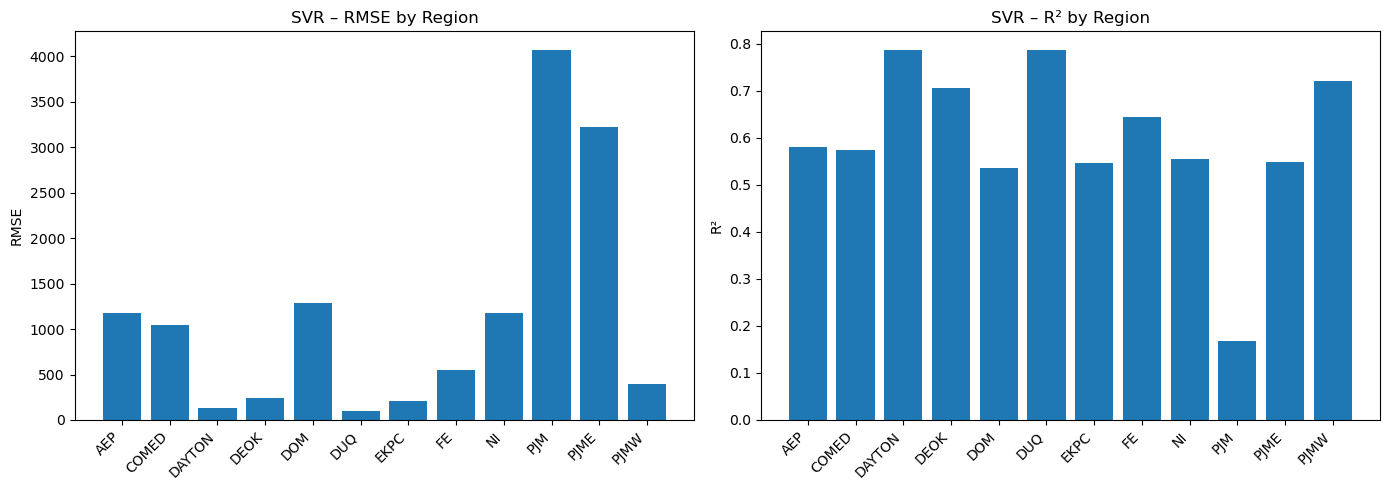

In [10]:
regions   = list(svr_results)
svr_rmses = [svr_results[r]["rmse"] for r in regions]
svr_r2s   = [svr_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, svr_rmses)
ax[0].set_title("SVR – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))                # set first …
ax[0].set_xticklabels(regions, rotation=45, ha="right")  # … then labels

# R²
ax[1].bar(regions, svr_r2s)
ax[1].set_title("SVR – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()


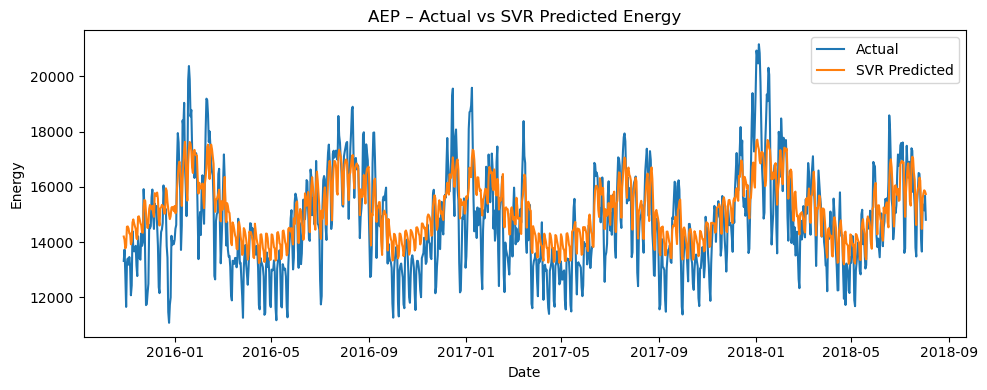

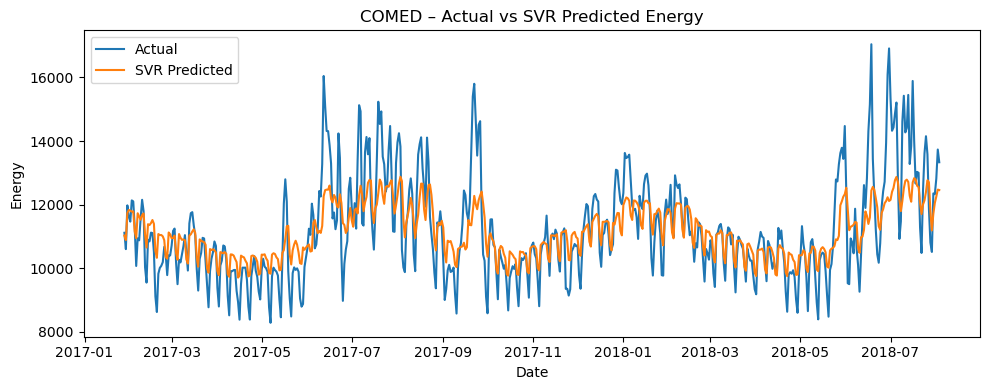

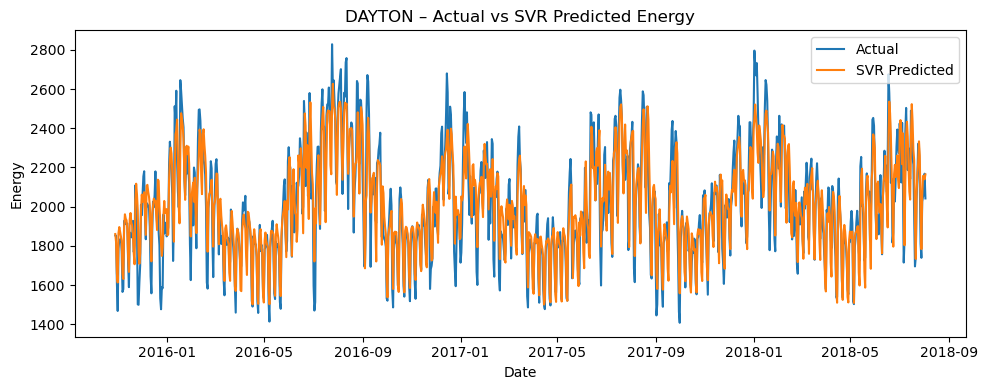

In [11]:
for region in regions[:3]:
    idx = svr_results[region]["index_test"]
    yt  = svr_results[region]["y_test"]
    yp  = svr_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="SVR Predicted")
    plt.title(f"{region} – Actual vs SVR Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:green">3. Random Forest ML model</span>

The code below demonstrates how to use the Random Forest (RF) machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to improve predictive accuracy and control overfitting.

**What the code does:**
- For each region, it trains a `RandomForestRegressor` model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use Random Forest?**
- Random Forest is robust to overfitting and can handle high-dimensional data well.
- It can model complex, non-linear relationships between features and the target variable.
- It is less sensitive to outliers and noise compared to individual decision trees.
- Random Forest provides feature importance scores, which can help in understanding which variables are most influential in the predictions.

In this notebook, Random Forest is used to model the relationship between temperature, seasonal effects, and energy consumption, offering a strong baseline and interpretability for regional energy demand forecasting.

In [12]:
rf_results = {}

for region, d in data_dict.items():
    rf_model = RandomForestRegressor(
        n_estimators=300,        # more trees → stabler scores
        max_depth=None,
        n_jobs=-1,               # use all CPUs
        random_state=42
    )
    rf_model.fit(d["X_train"], d["y_train"])

    y_pred = rf_model.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    rf_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

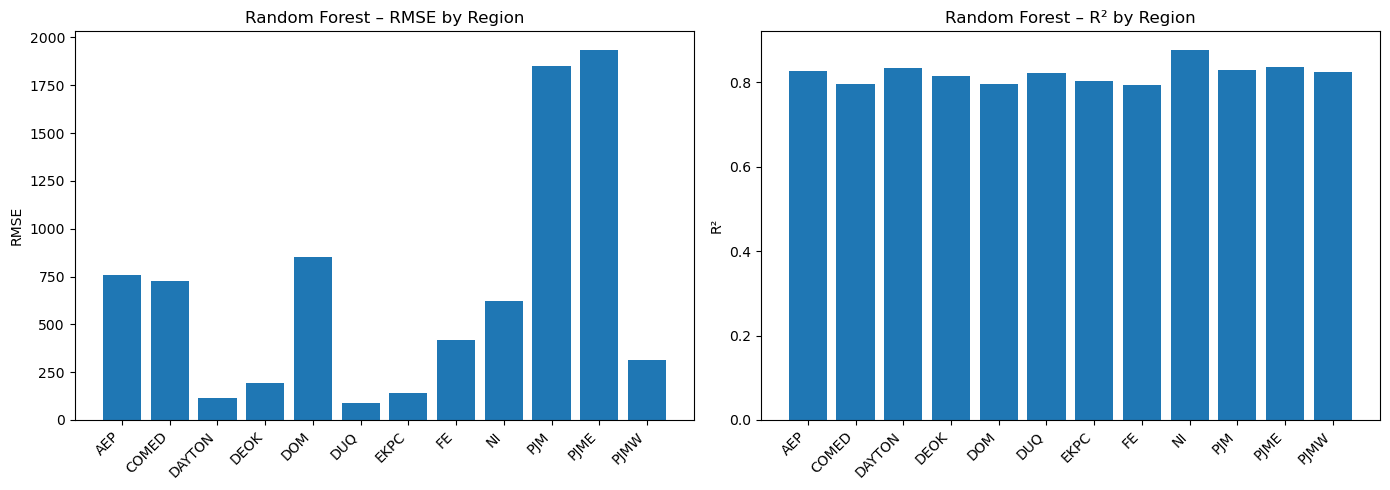

In [13]:
regions  = list(rf_results)
rf_rmses = [rf_results[r]["rmse"] for r in regions]
rf_r2s   = [rf_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, rf_rmses)
ax[0].set_title("Random Forest – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha="right")

# R²
ax[1].bar(regions, rf_r2s)
ax[1].set_title("Random Forest – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()

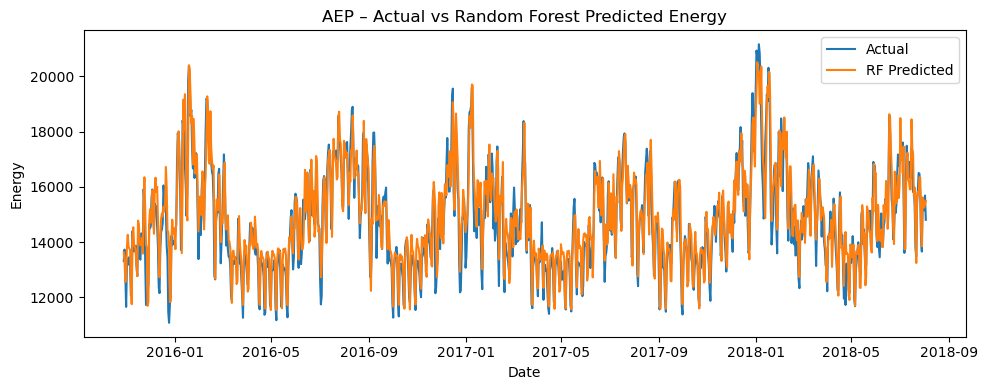

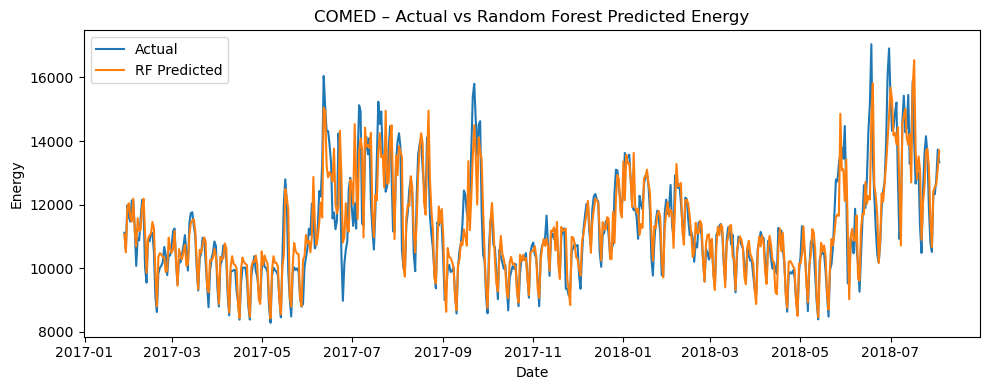

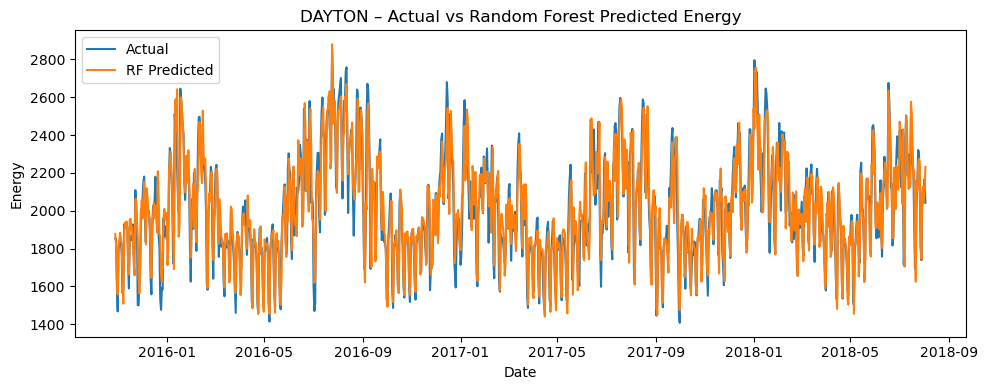

In [14]:
for region in regions[:3]:
    idx = rf_results[region]["index_test"]
    yt  = rf_results[region]["y_test"]
    yp  = rf_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="RF Predicted")
    plt.title(f"{region} – Actual vs Random Forest Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:green">4. Linear Regression ML model</span>

The code below demonstrates how to use the Linear Regression (LR) machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. Linear Regression is a fundamental and widely used regression technique that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data.

**What the code does:**
- For each region, it trains a `LinearRegression` model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use Linear Regression?**
- Linear Regression is simple, interpretable, and computationally efficient.
- It provides a baseline for regression tasks and helps in understanding the linear relationships between features and the target variable.
- It is less prone to overfitting when the number of features is not too large and the relationship is approximately linear.
- Coefficients from the model can be used to interpret the influence of each feature on energy consumption.

In this notebook, Linear Regression is used to model the relationship between temperature, seasonal effects, and energy consumption, providing a straightforward and interpretable approach for regional energy demand forecasting.

In [15]:
lr_results = {}

for region, d in data_dict.items():
    lr_model = make_pipeline(
        StandardScaler(),        # centre / scale features
        LinearRegression()
    )
    lr_model.fit(d["X_train"], d["y_train"])

    y_pred = lr_model.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    lr_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }


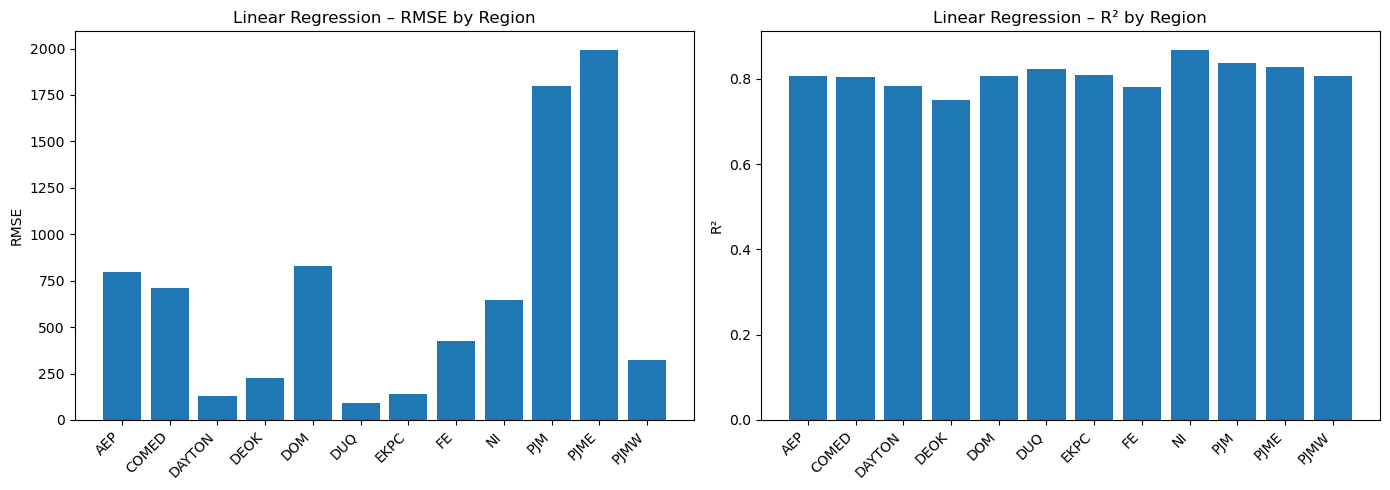

In [16]:
regions = list(lr_results)
lr_rmses = [lr_results[r]["rmse"] for r in regions]
lr_r2s   = [lr_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, lr_rmses)
ax[0].set_title("Linear Regression – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha="right")

# R²
ax[1].bar(regions, lr_r2s)
ax[1].set_title("Linear Regression – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()

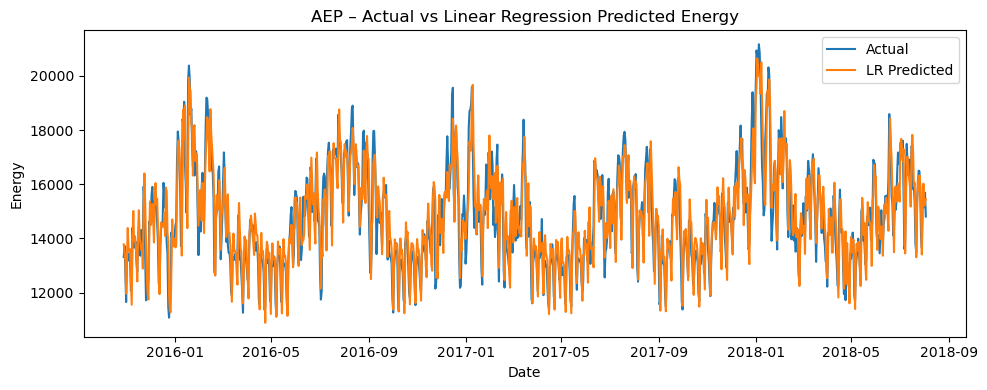

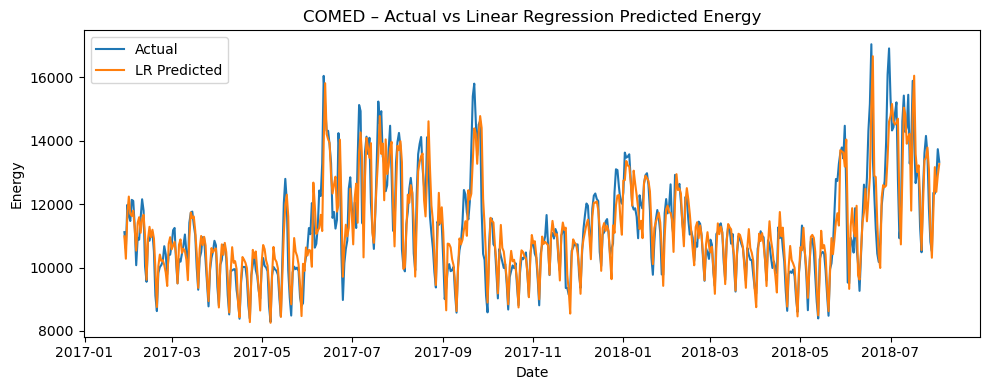

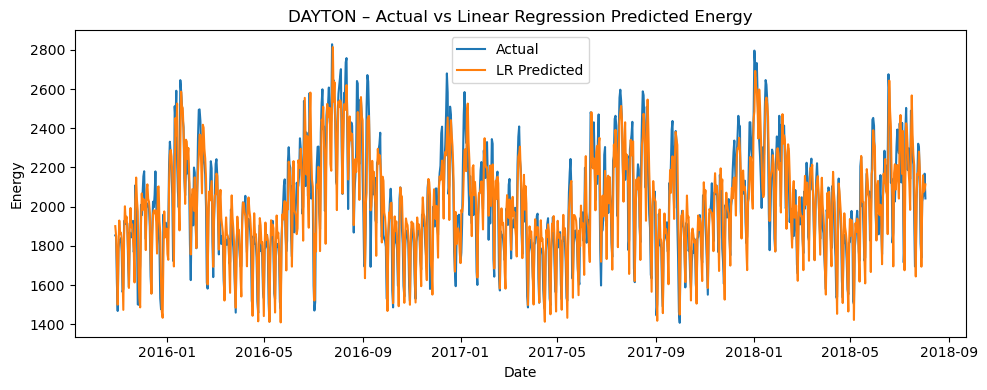

In [17]:
for region in regions[:3]:
    idx = lr_results[region]["index_test"]
    yt  = lr_results[region]["y_test"]
    yp  = lr_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="LR Predicted")
    plt.title(f"{region} – Actual vs Linear Regression Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:orange">5. LightGBM ML model</span>

The code below demonstrates how to use the LightGBM (Light Gradient Boosting Machine) machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. LightGBM is a highly efficient and fast gradient boosting framework that uses tree-based learning algorithms, making it popular for large-scale and high-performance machine learning tasks.

**What the code does:**
- For each region, it trains a `LGBMRegressor` model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use LightGBM?**
- LightGBM is optimized for speed and memory efficiency, making it suitable for large datasets.
- It supports parallel and GPU learning, which accelerates training.
- It can handle categorical features directly and is robust to overfitting.
- LightGBM can capture complex, non-linear relationships in the data and often achieves high predictive accuracy.

In this notebook, LightGBM is used to model the relationship between temperature, seasonal effects, and energy consumption, providing fast and accurate predictions for regional energy demand forecasting.

In [18]:
lgbm_results = {}

for region, d in data_dict.items():
    # Ensure both X_train and X_test are DataFrames with the same columns
    if isinstance(d["X_train"], np.ndarray):
        d["X_train"] = pd.DataFrame(d["X_train"])
    if isinstance(d["X_test"], np.ndarray):
        d["X_test"] = pd.DataFrame(d["X_test"], columns=d["X_train"].columns)

    # Initialize model
    lgbm_model = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="regression",
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )

    # Fit the model
    lgbm_model.fit(
        d["X_train"], d["y_train"],
        callbacks=[lgb.log_evaluation(period=0)]  # silence eval logging
    )

    # Predict and evaluate
    y_pred = lgbm_model.predict(d["X_test"])
    rmse = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2 = r2_score(d["y_test"], y_pred)

    # Save results
    lgbm_results[region] = {
        "rmse": rmse,
        "r2": r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

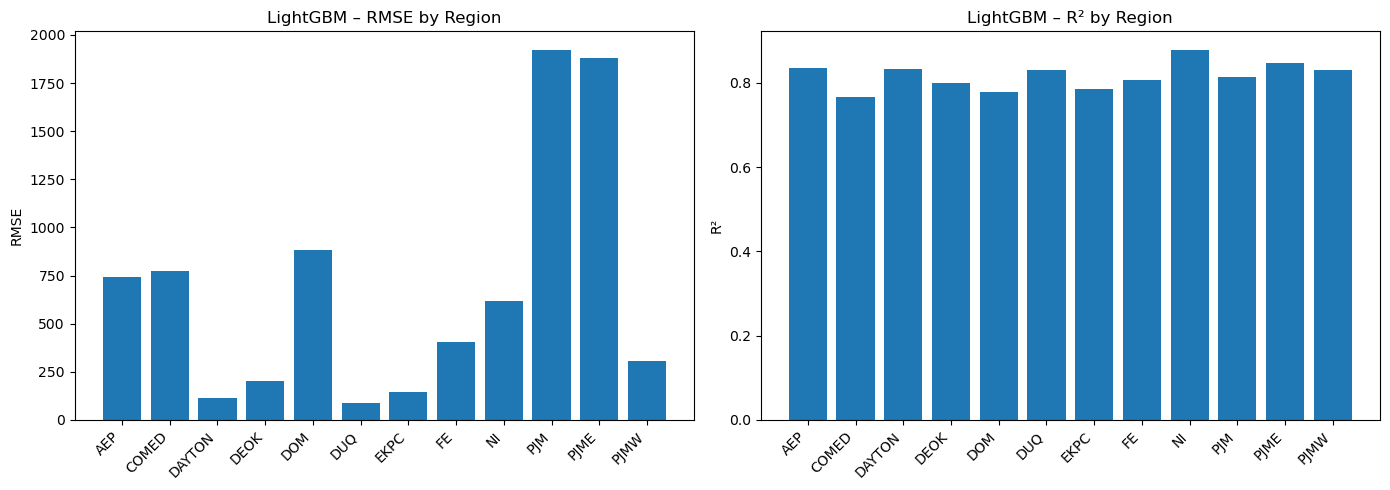

In [19]:
regions   = list(lgbm_results)          # derive directly from results
lgbm_rmses = [lgbm_results[r]["rmse"] for r in regions]
lgbm_r2s   = [lgbm_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, lgbm_rmses)
ax[0].set_title("LightGBM – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha='right')

# R²
ax[1].bar(regions, lgbm_r2s)
ax[1].set_title("LightGBM – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha='right')

plt.tight_layout()
plt.show()

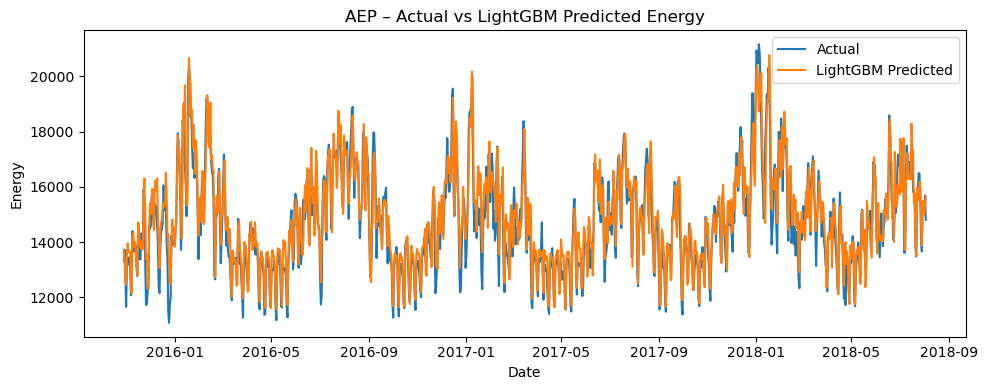

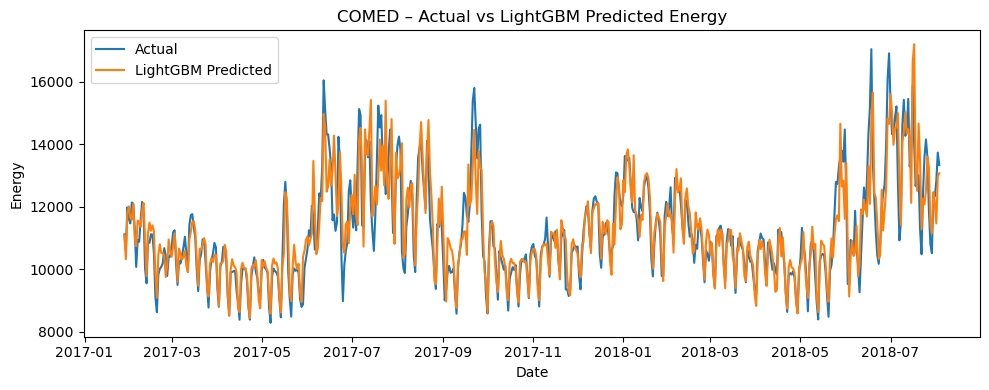

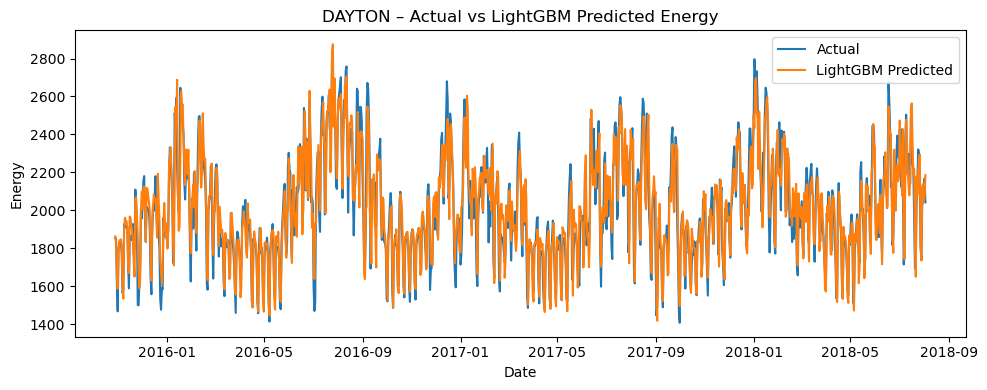

In [20]:
for region in regions[:3]:
    idx = lgbm_results[region]["index_test"]
    yt  = lgbm_results[region]["y_test"]
    yp  = lgbm_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="LightGBM Predicted")
    plt.title(f"{region} – Actual vs LightGBM Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:orange">6. Gradient Boosting ML model</span>

In [21]:
gb_results = {}

for region, d in data_dict.items():
    gb_model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
    gb_model.fit(d["X_train"], d["y_train"])

    y_pred = gb_model.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    gb_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

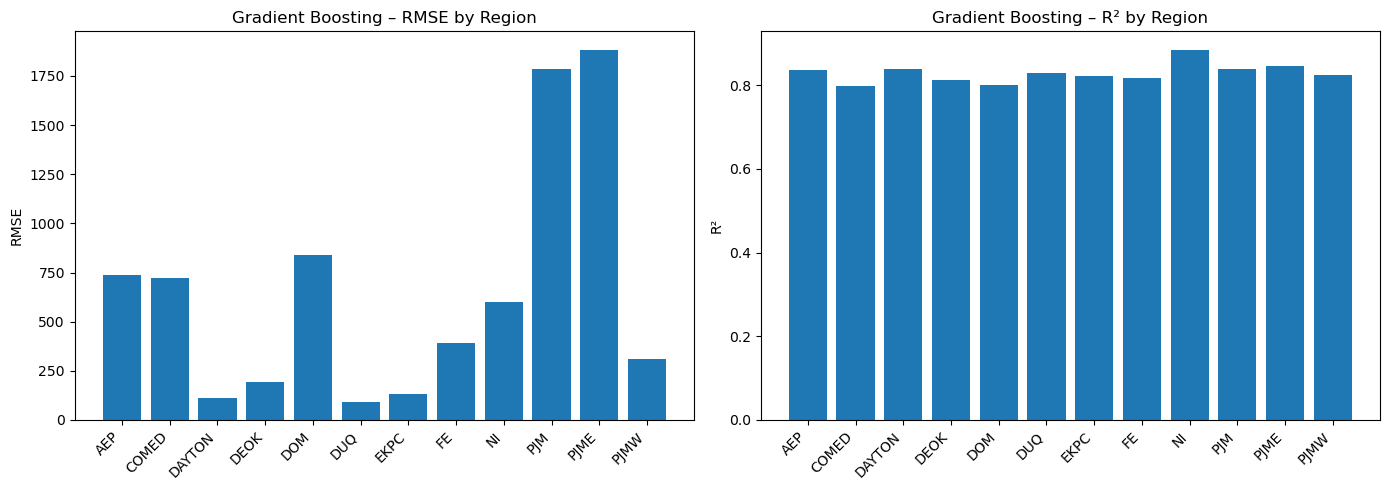

In [22]:
regions = list(gb_results)
gb_rmses = [gb_results[r]["rmse"] for r in regions]
gb_r2s   = [gb_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, gb_rmses)
ax[0].set_title("Gradient Boosting – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha="right")

# R²
ax[1].bar(regions, gb_r2s)
ax[1].set_title("Gradient Boosting – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()

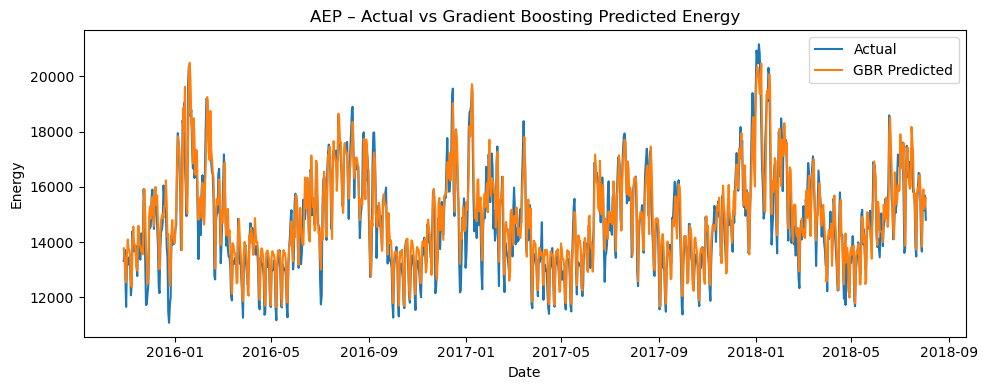

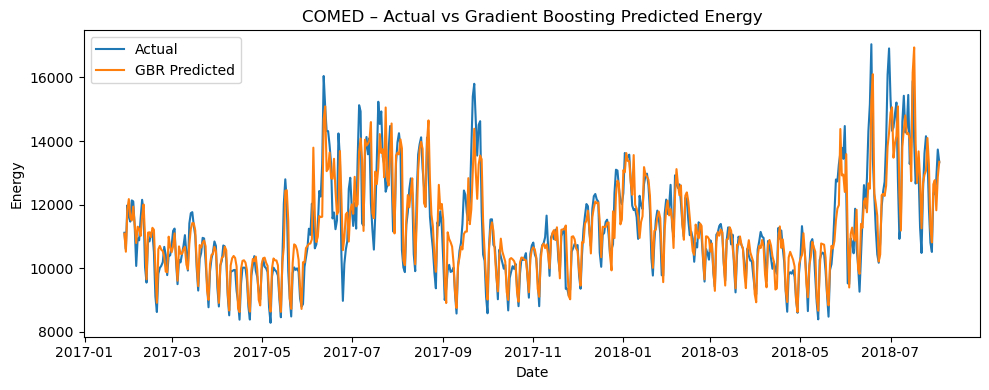

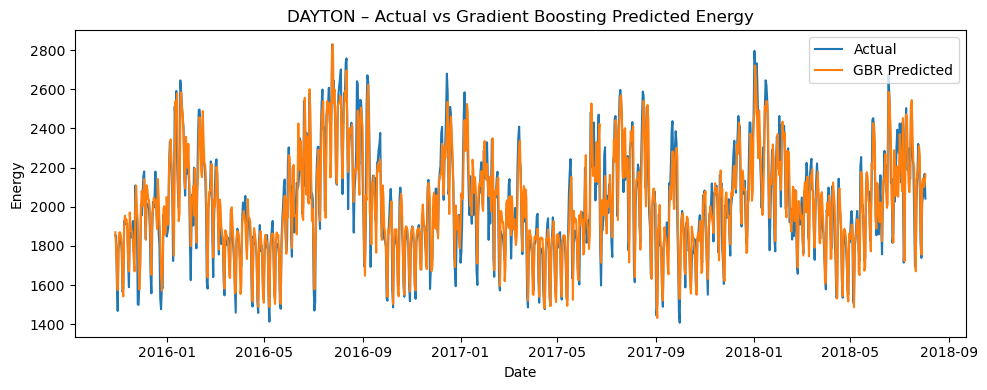

In [23]:
for region in regions[:3]:
    idx = gb_results[region]["index_test"]
    yt  = gb_results[region]["y_test"]
    yp  = gb_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="GBR Predicted")
    plt.title(f"{region} – Actual vs Gradient Boosting Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:pink">7. Ridge regression ML model</span>

The code below demonstrates how to use the Ridge Regression (Ridge) machine learning algorithm to predict energy consumption for different regions based on weather and seasonal features. Ridge Regression is a regularized version of linear regression that adds an L2 penalty (the squared magnitude of coefficients) to the loss function, which helps to prevent overfitting and manage multicollinearity among features.

**What the code does:**
- For each region, it trains a `Ridge` regression model using the training data (`X_train`, `y_train`).
- It predicts energy values on the test set (`X_test`).
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use Ridge Regression?**
- Ridge Regression is effective when there is multicollinearity (correlated features) in the data, as it shrinks the coefficients and reduces model variance.
- The L2 regularization helps to prevent overfitting, especially when the number of features is large relative to the number of observations.
- Ridge provides a balance between bias and variance, often improving generalization performance compared to standard linear regression.
- It is simple, interpretable, and computationally efficient.

In this notebook, Ridge Regression is used to model the relationship between temperature, seasonal effects, and energy consumption, providing a robust and regularized approach for regional energy demand forecasting.

In [24]:
ridge_results = {}

for region, d in data_dict.items():
    ridge_model = make_pipeline(
        StandardScaler(),          # keeps coefficients well-scaled
        Ridge(alpha=1.0, random_state=42)
    )
    ridge_model.fit(d["X_train"], d["y_train"])

    y_pred = ridge_model.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    ridge_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

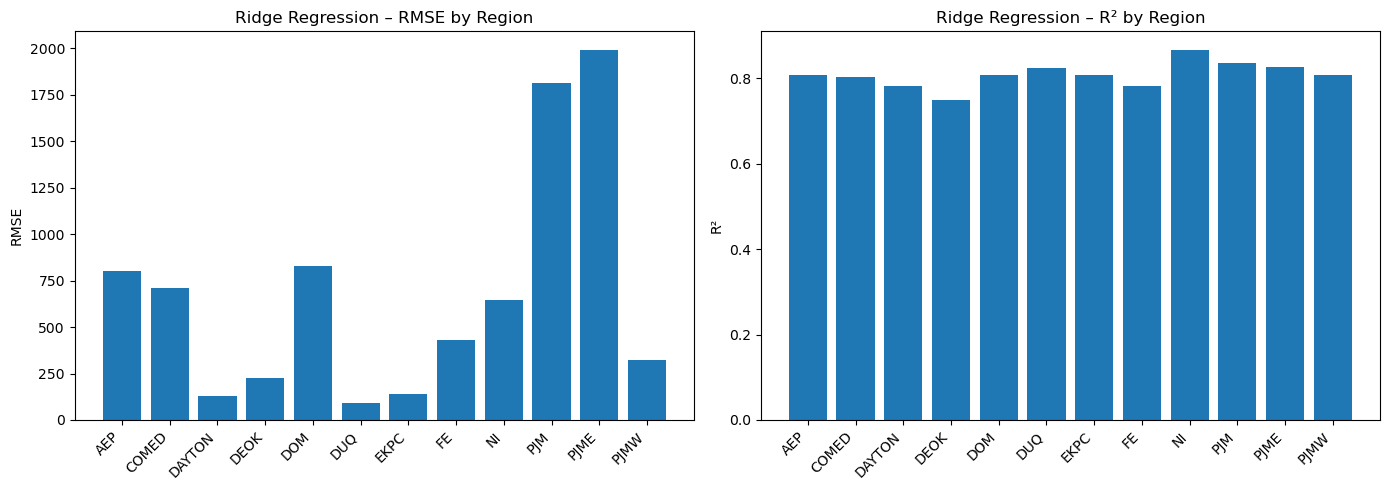

In [25]:
regions    = list(ridge_results)               # ensure sync
ridge_rmses = [ridge_results[r]["rmse"] for r in regions]
ridge_r2s   = [ridge_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, ridge_rmses)
ax[0].set_title("Ridge Regression – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha="right")

# R²
ax[1].bar(regions, ridge_r2s)
ax[1].set_title("Ridge Regression – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha="right")

plt.tight_layout()
plt.show()

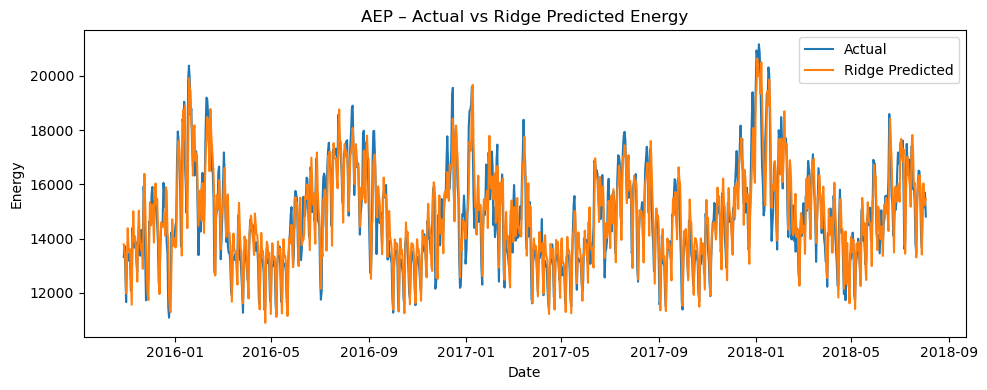

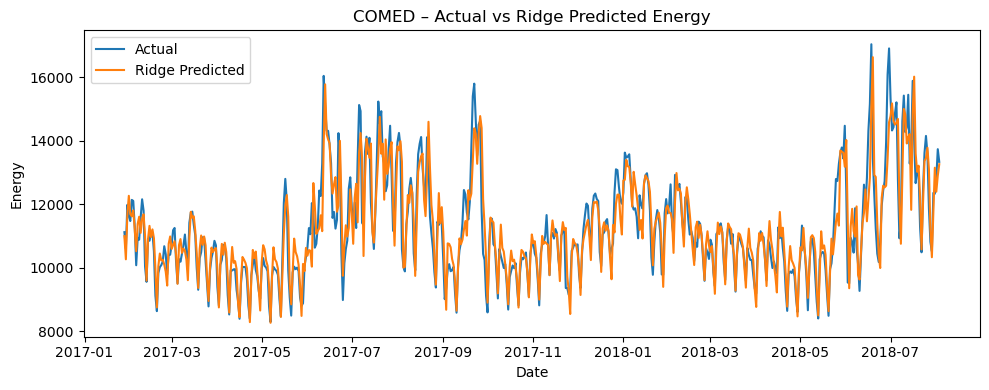

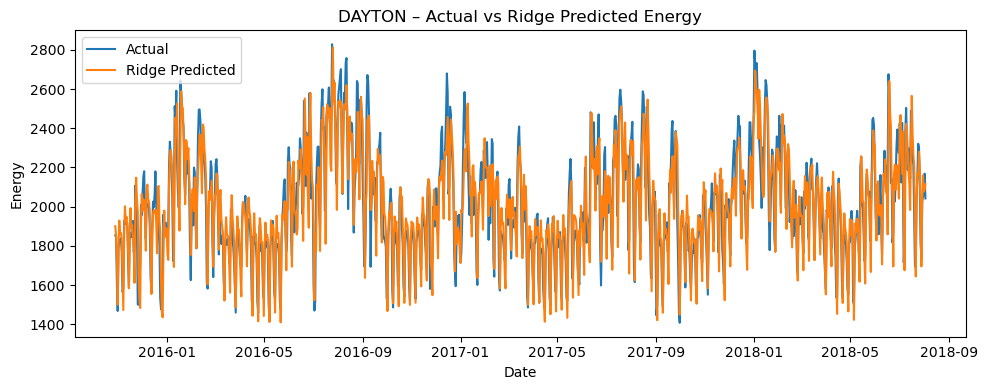

In [26]:
for region in regions[:3]:
    idx = ridge_results[region]["index_test"]
    yt  = ridge_results[region]["y_test"]
    yp  = ridge_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="Ridge Predicted")
    plt.title(f"{region} – Actual vs Ridge Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:green">8. SVR pipeline ML model</span>

The code below demonstrates how to use a machine learning pipeline that combines feature scaling, feature selection, dimensionality reduction, and Support Vector Regression (SVR) to predict energy consumption for different regions. This approach leverages the strengths of each preprocessing step to improve the performance of SVR, as evidenced by the increased accuracy compared to a plain SVR model.

**What the code does:**
- For each region, it constructs a `Pipeline` consisting of:
    - `StandardScaler`: Standardizes features by removing the mean and scaling to unit variance, which is important for SVR since it is sensitive to the scale of input features.
    - `SelectKBest`: Selects the best features based on univariate linear regression tests, helping to remove irrelevant or less informative features.
    - `PCA`: Applies Principal Component Analysis to reduce dimensionality while retaining 95% of the variance, which can help to denoise the data and reduce overfitting.
    - `SVR`: Fits a Support Vector Regression model with an RBF kernel to capture non-linear relationships.
- The pipeline is trained on the training data and evaluated on the test set.
- Model performance is assessed using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- Results are visualized for all regions, and actual vs. predicted energy values are plotted for selected regions.

**Why does this pipeline improve SVR accuracy?**
- **Scaling** ensures all features contribute equally to the SVR model, preventing features with larger scales from dominating.
- **Feature selection** removes noise and irrelevant features, allowing the model to focus on the most predictive variables.
- **Dimensionality reduction (PCA)** helps to further reduce noise and multicollinearity, making the SVR model more robust and less prone to overfitting.
- **SVR** benefits from these preprocessing steps, leading to better generalization and improved accuracy, as seen in the higher R² scores.

By integrating these preprocessing steps, the pipeline addresses common challenges in regression modeling and enhances the predictive power of SVR for regional energy demand forecasting.

In [27]:
svr_pipe_results = {}

for region, d in data_dict.items():
    svr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),   # keep 95 % variance
        ('svr',    SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)),
    ])
    svr_pipe.fit(d["X_train"], d["y_train"])

    y_pred = svr_pipe.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    svr_pipe_results[region] = {
        "rmse":  rmse,
        "r2":    r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

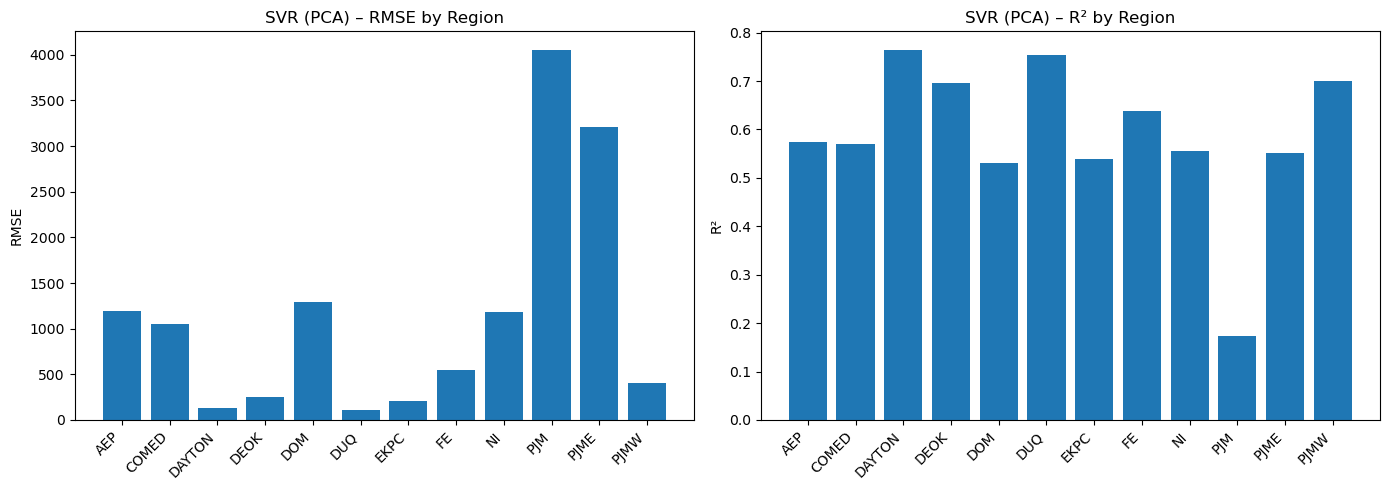

In [28]:
regions        = list(svr_pipe_results)
svr_pipe_rmses = [svr_pipe_results[r]["rmse"] for r in regions]
svr_pipe_r2s   = [svr_pipe_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, svr_pipe_rmses)
ax[0].set_title("SVR (PCA) – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha='right')

# R²
ax[1].bar(regions, svr_pipe_r2s)
ax[1].set_title("SVR (PCA) – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha='right')

plt.tight_layout()
plt.show()

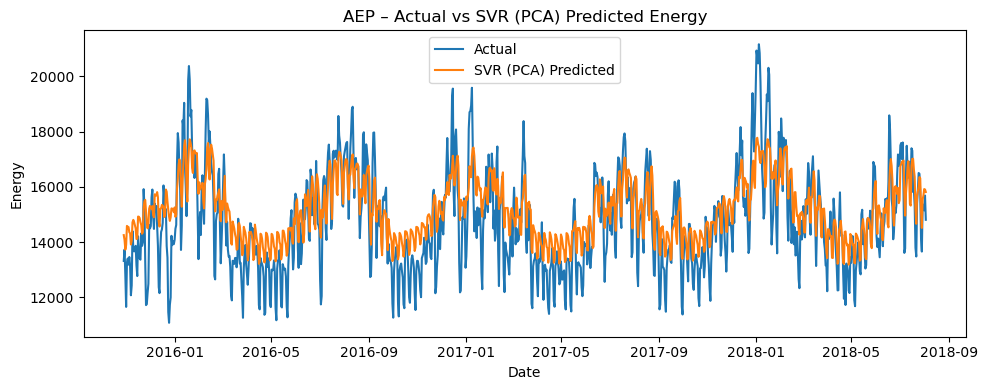

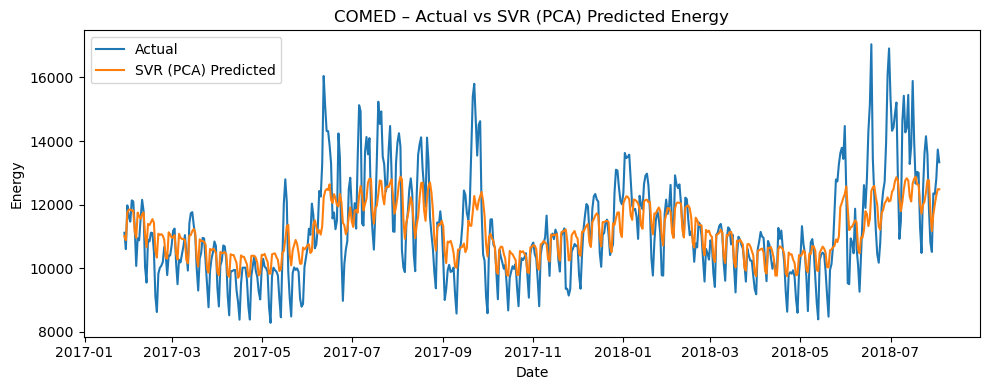

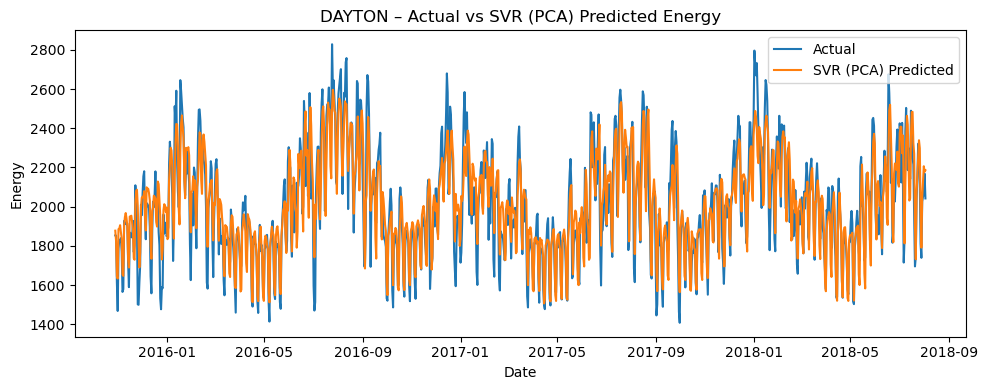

In [29]:
for region in regions[:3]:
    idx = svr_pipe_results[region]["index_test"]
    yt  = svr_pipe_results[region]["y_test"]
    yp  = svr_pipe_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="SVR (PCA) Predicted")
    plt.title(f"{region} – Actual vs SVR (PCA) Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:blue">9. XGBoost + SVR pipeline ML model</span>

The code below demonstrates how to use a stacking ensemble that combines an SVR pipeline and XGBoost to predict energy consumption for different regions based on weather and seasonal features. This approach leverages the strengths of both SVR (with preprocessing) and XGBoost by stacking their predictions, allowing a final XGBoost model to learn from both sets of outputs for improved accuracy.

**What the code does:**
- For each region, it builds a `StackingRegressor` with two base estimators:
    - An SVR pipeline that includes feature scaling, feature selection, and PCA for dimensionality reduction, followed by an SVR model.
    - An XGBoost regressor.
- The outputs of these base models are combined and used as input features for a final XGBoost regressor (the meta-learner).
- The stacked model is trained on the training data and evaluated on the test set.
- Model performance is assessed using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- Results are visualized for all regions, and actual vs. predicted energy values are plotted for selected regions.

**Why does this stacking approach work?**
- **Model diversity:** SVR and XGBoost capture different aspects of the data; SVR is effective for smooth, non-linear relationships after preprocessing, while XGBoost excels at handling complex interactions and outliers.
- **Preprocessing pipeline:** The SVR pipeline ensures that features are well-scaled, relevant, and denoised before regression, which helps SVR perform optimally.
- **Meta-learning:** The final XGBoost regressor (meta-learner) can learn how to best combine the predictions from both base models, correcting their individual weaknesses and leveraging their strengths.
- **Reduced overfitting:** By combining multiple models, stacking can reduce the risk of overfitting compared to relying on a single model.
- **Improved accuracy:** The ensemble often achieves better predictive performance than any individual model, as evidenced by higher R² scores and lower RMSE.

This stacking ensemble provides a robust and flexible framework for regional energy demand forecasting, taking advantage of both advanced preprocessing and powerful machine learning algorithms.

In [30]:
svr_xgb_stack_results = {}

for region, d in data_dict.items():
    # 1️⃣  SVR pipeline (scale → PCA → SVR)
    svr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('svr',    SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)),
    ])

    # 2️⃣  Base XGB (no scaling needed)
    xgb_base = XGBRegressor(
        n_estimators=300,
        learning_rate=0.06,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    # 3️⃣  Final estimator (small XGB)
    xgb_final = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    stack = StackingRegressor(
        estimators=[('svr', svr_pipe), ('xgb', xgb_base)],
        final_estimator=xgb_final,
        passthrough=True
    )

    stack.fit(d["X_train"], d["y_train"])

    y_pred = stack.predict(d["X_test"])
    rmse   = np.sqrt(mean_squared_error(d["y_test"], y_pred))
    r2     = r2_score(d["y_test"], y_pred)

    svr_xgb_stack_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": d["y_test"],
        "y_pred": y_pred,
        "index_test": d["index_test"],
    }

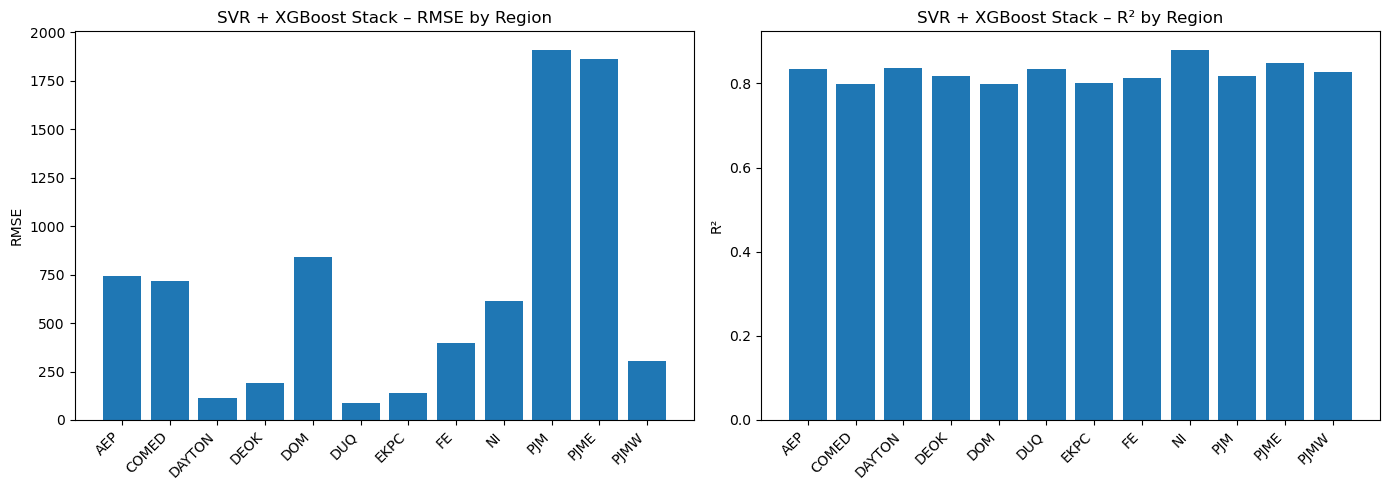

In [31]:
regions    = list(svr_xgb_stack_results)          # sync with actual results
stack_rmses = [svr_xgb_stack_results[r]["rmse"] for r in regions]
stack_r2s   = [svr_xgb_stack_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax[0].bar(regions, stack_rmses)
ax[0].set_title("SVR + XGBoost Stack – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha='right')

# R²
ax[1].bar(regions, stack_r2s)
ax[1].set_title("SVR + XGBoost Stack – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha='right')

plt.tight_layout()
plt.show()

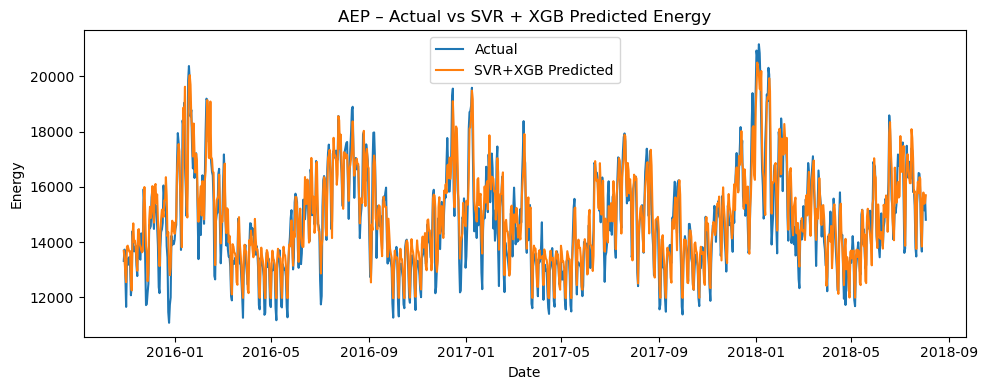

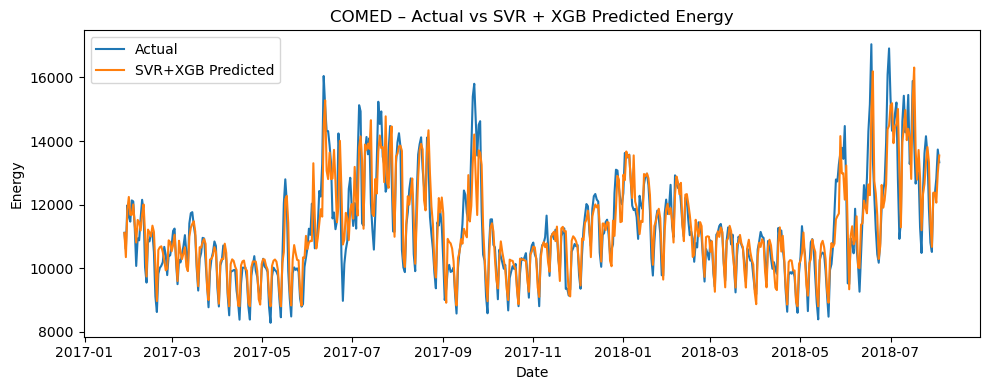

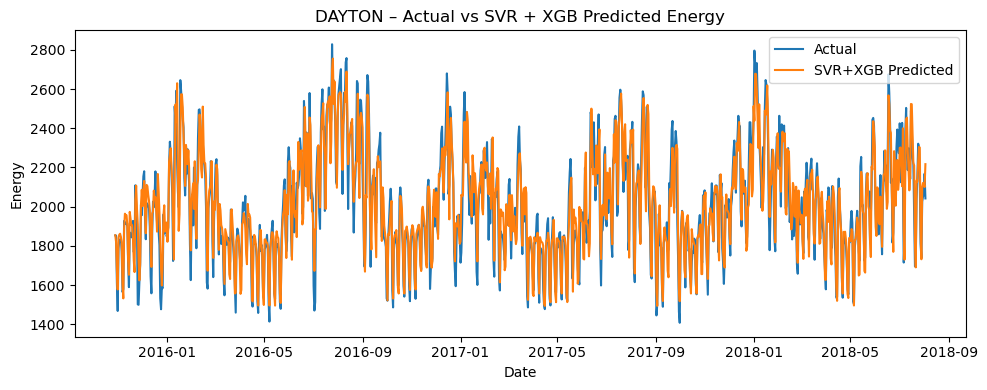

In [32]:
for region in regions[:3]:
    idx = svr_xgb_stack_results[region]["index_test"]
    yt  = svr_xgb_stack_results[region]["y_test"]
    yp  = svr_xgb_stack_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="SVR+XGB Predicted")
    plt.title(f"{region} – Actual vs SVR + XGB Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

## <span style="color:pink">10. LSTM ML model</span>

The code below demonstrates how to use a Long Short-Term Memory (LSTM) neural network to predict energy consumption for different regions based on weather, seasonal, and historical energy features. LSTM is a type of recurrent neural network (RNN) that is well-suited for modeling sequential and time series data due to its ability to capture long-term dependencies and temporal patterns.

**What the code does:**
- For each region, it transforms the feature and target arrays into sequences of a fixed length (`SEQ_LEN`), so the LSTM can learn from historical windows of data.
- It builds and trains an LSTM-based neural network using the training sequences, with dropout for regularization and dense layers for additional learning capacity.
- It evaluates model performance using RMSE (Root Mean Squared Error) and R² (coefficient of determination) metrics.
- It visualizes the RMSE and R² scores for all regions.
- It plots actual vs. predicted energy values for a few example regions.

**Why use LSTM?**
- LSTM networks are specifically designed to handle sequential data and can learn complex temporal relationships, making them ideal for time series forecasting.
- They are effective at capturing both short-term and long-term dependencies in data, which is important for energy demand prediction where past consumption and weather patterns influence future values.
- LSTMs can model non-linear and non-stationary processes, outperforming traditional models when the data exhibits complex temporal dynamics.
- They are robust to noise and can generalize well when trained with sufficient data.

In this notebook, LSTM is used to model the relationship between historical energy usage, temperature, seasonal effects, and future energy demand, providing a powerful deep learning approach for regional energy forecasting.

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [34]:
tf.random.set_seed(42)   # reproducibility

SEQ_LEN = 7              # past 7 days → predict day 8
BATCH  = 32
EPOCHS = 100

def make_sequences(X, y, seq_len):
    """Cast tabular X, y into overlapping LSTM windows."""
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(xs), np.array(ys)

lstm_results = {}


In [35]:
for region, d in data_dict.items():
    # ── scale features ─────────────────────────────
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(d["X_train"])
    X_te_scaled = scaler.transform(d["X_test"])

    # ── build seq windows ──────────────────────────
    X_tr_seq, y_tr_seq = make_sequences(X_tr_scaled, d["y_train"], SEQ_LEN)
    X_te_seq, y_te_seq = make_sequences(X_te_scaled, d["y_test"],  SEQ_LEN)
    idx_test_seq       = d["index_test"][SEQ_LEN:]

    # ── define LSTM model ──────────────────────────
    model = Sequential([
        Bidirectional(LSTM(64, activation='relu'), input_shape=(SEQ_LEN, X_tr_seq.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse')

    # ── fit ────────────────────────────────────────
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    model.fit(
        X_tr_seq, y_tr_seq,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=[es],
        verbose=0
    )

    # ── evaluate ───────────────────────────────────
    y_pred = model.predict(X_te_seq, verbose=0).flatten()
    rmse   = np.sqrt(mean_squared_error(y_te_seq, y_pred))
    r2     = r2_score(y_te_seq, y_pred)

    lstm_results[region] = {
        "rmse": rmse,
        "r2":   r2,
        "y_test": y_te_seq,
        "y_pred": y_pred,
        "index_test": idx_test_seq,
    }

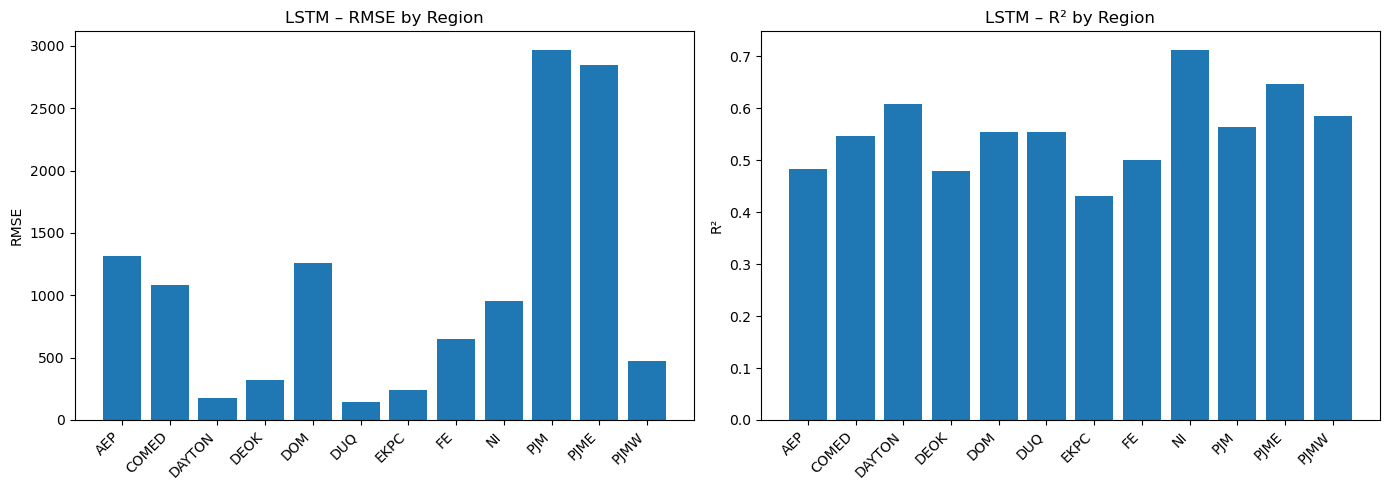

In [36]:
regions    = list(lstm_results)
lstm_rmses = [lstm_results[r]["rmse"] for r in regions]
lstm_r2s   = [lstm_results[r]["r2"]   for r in regions]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(regions, lstm_rmses)
ax[0].set_title("LSTM – RMSE by Region")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(np.arange(len(regions)))
ax[0].set_xticklabels(regions, rotation=45, ha='right')

ax[1].bar(regions, lstm_r2s)
ax[1].set_title("LSTM – R² by Region")
ax[1].set_ylabel("R²")
ax[1].set_xticks(np.arange(len(regions)))
ax[1].set_xticklabels(regions, rotation=45, ha='right')

plt.tight_layout()
plt.show()

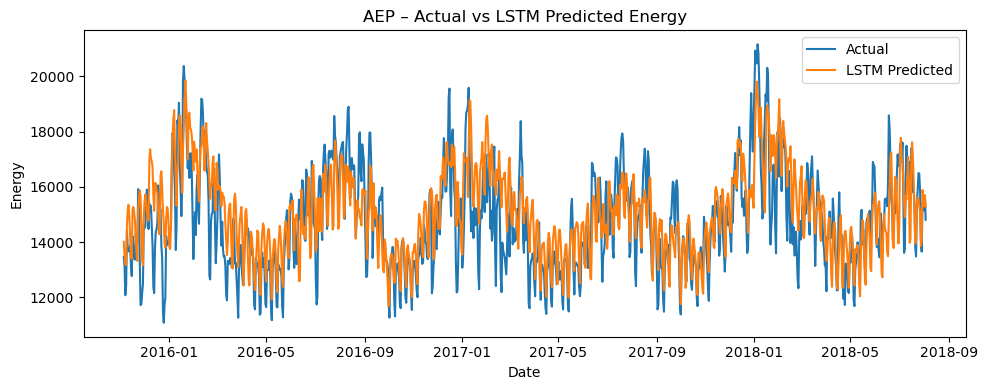

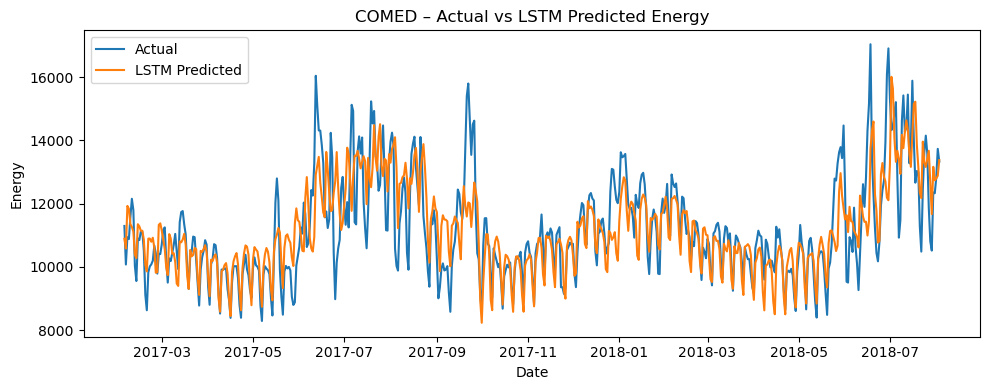

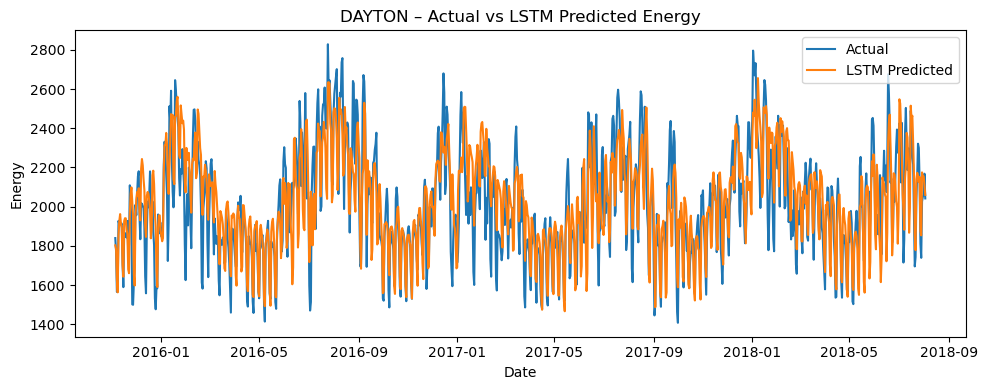

In [37]:
for region in regions[:3]:
    idx = lstm_results[region]["index_test"]
    yt  = lstm_results[region]["y_test"]
    yp  = lstm_results[region]["y_pred"]

    plt.figure(figsize=(10, 4))
    plt.plot(idx, yt, label="Actual")
    plt.plot(idx, yp, label="LSTM Predicted")
    plt.title(f"{region} – Actual vs LSTM Predicted Energy")
    plt.xlabel("Date")
    plt.ylabel("Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Model Comparison

In [38]:
import pandas as pd

# Prepare model names and their corresponding RMSE and R2 lists
model_names = [
    "XGBoost", "SVR", "Random Forest", "Linear Regression", "LightGBM",
    "Gradient Boosting", "Ridge Regression", "SVR (PCA)", "SVR+XGB Stack", "LSTM"
]

# Gather RMSE and R2 lists for each model (order matches model_names)
rmse_lists = [
    rmses,                # XGBoost
    svr_rmses,            # SVR
    rf_rmses,             # Random Forest
    lr_rmses,             # Linear Regression
    lgbm_rmses,           # LightGBM
    gb_rmses,             # Gradient Boosting
    ridge_rmses,          # Ridge Regression
    svr_pipe_rmses,       # SVR (PCA)
    stack_rmses,          # SVR+XGB Stack
    lstm_rmses            # LSTM
]

r2_lists = [
    r2s,                  # XGBoost
    svr_r2s,              # SVR
    rf_r2s,               # Random Forest
    lr_r2s,               # Linear Regression
    lgbm_r2s,             # LightGBM
    gb_r2s,               # Gradient Boosting
    ridge_r2s,            # Ridge Regression
    svr_pipe_r2s,         # SVR (PCA)
    stack_r2s,            # SVR+XGB Stack
    lstm_r2s              # LSTM
]

avg_rmse = [np.mean(lst) for lst in rmse_lists]
std_rmse = [np.std(lst)  for lst in rmse_lists]
avg_r2   = [np.mean(lst) for lst in r2_lists]
std_r2   = [np.std(lst)  for lst in r2_lists]

# Create DataFrame for comparison
compare_df = pd.DataFrame({
    "Model"      : model_names,
    "RMSE (mean)": avg_rmse,
    "RMSE (std)" : std_rmse,
    "R² (mean)"  : avg_r2,
    "R² (std)"   : std_r2
}).sort_values("RMSE (mean)")          # lowest error first

compare_df.reset_index(drop=True, inplace=True)
compare_df

Model  RMSE (mean)   RMSE (std)  R² (mean)  R² (std)
0  Gradient Boosting   649.643057   585.998482   0.829080  0.022131
1      SVR+XGB Stack   660.185072   602.666195   0.825701  0.022590
2            XGBoost   660.188476   596.677164   0.824246  0.026965
3      Random Forest   666.973571   604.391809   0.820769  0.022391
4           LightGBM   673.087473   608.319708   0.817048  0.030101
5  Linear Regression   675.765946   602.787195   0.808515  0.028680
6   Ridge Regression   676.667060   604.175861   0.808414  0.028291
7               LSTM  1035.764163   926.240273   0.555470  0.074402
8                SVR  1133.452673  1211.808215   0.595755  0.157073
9          SVR (PCA)  1136.575946  1206.012758   0.587175  0.148713

---

## Model Evaluation Metrics: RMSE and R²

When comparing machine learning models for energy prediction, two key metrics are used:

### 1. **Root Mean Squared Error (RMSE)**

-   **Definition:** RMSE measures the average magnitude of the errors between predicted and actual values. It is the square root of the average of squared differences.
    
-   **Interpretation:**
    
    -   **Low RMSE:** Indicates that the model's predictions are close to the actual values, meaning higher accuracy.
        
    -   **High RMSE:** Indicates larger errors in predictions, meaning lower accuracy.
        
-   **Units:** RMSE is in the same units as the target variable (here, energy).
    

### 2. **R² Score (Coefficient of Determination)**

-   **Definition:** R² measures the proportion of variance in the dependent variable that is predictable from the independent variables.
    
-   **Interpretation:**
    
    -   **R² = 1:** Perfect prediction.
        
    -   **R² = 0:** Model predicts no better than the mean of the data.
        
    -   **R² < 0:** Model performs worse than simply predicting the mean.
        
    -   **Higher R²:** Indicates better model performance.
        

----------

## Comparing Models

### **Best Models**

-   Models with the **lowest RMSE** and **highest R²** are considered the best, as they produce predictions closest to actual values and explain the most variance.
    
-   **Gradient Boosting** performed best overall, with the **lowest RMSE (649.64)** and **highest R² (0.829)**.
    
-   **SVR + XGBoost Stacking** and **XGBoost** followed closely, with **RMSE around 660** and strong **R² (~0.825)**.
    

### **Mid-Range Models**

-   **Random Forest** and **LightGBM** had decent performance, but showed **slightly higher error** and **lower explanatory power** than the top models.
    
-   **Linear Regression** and **Ridge Regression** were consistent, but had limited ability to model non-linear relationships.
    

### **Poor Performing Models**

-   **LSTM** showed **very high RMSE (1035.76)** and the **lowest R² (0.555)**, suggesting poor fit or overfitting.
    
-   **SVR** and **SVR with PCA** had the **worst overall performance**, with **RMSE > 1100** and **R² < 0.60**.
    

----------

## Why Some Models Perform Better

-   **Ensemble models** (e.g., **Gradient Boosting**, **XGBoost**, **Random Forest**):
    
    -   Capture complex, non-linear feature interactions.
        
    -   Reduce variance and typically perform well on structured/tabular data.
        
-   **Stacked models**:
    
    -   Combine strengths of different models (e.g., **SVR’s margin handling** + **XGBoost’s tree-based depth**).
        
    -   Improve generalization by offsetting individual model weaknesses.
        
-   **Neural networks (LSTM)**:
    
    -   Require **large datasets** and **careful tuning**.
        
    -   Struggle without a clear temporal structure or proper training strategy.
        
-   **Linear models**:
    
    -   Fast and interpretable.
        
    -   Often underperform on tasks with **non-linear patterns**, common in energy data.
        

----------

## Conclusion

-   **Low RMSE** and **high R²** are key indicators of a model’s predictive power and reliability.
    
-   **Gradient Boosting** emerged as the **top-performing model** in this workflow.
    
-   **Stacked ensembles** and **tree-based models** (e.g., **XGBoost**, **Random Forest**) also delivered **strong, consistent results**.
    
-   **Linear models** and **SVR-based models** underperformed, and **LSTM was not suitable** for this dataset without further tuning.
    
-   For **regional energy forecasting**, **ensemble methods consistently provide the best performance**.